Load input. Normalized proteomics from CCLE was downloaded from [here](https://gygi.hms.harvard.edu/data/ccle/protein_quant_current_normalized.csv.gz):

Metastatic potential was obtained from [Metmap 500](https://depmap.org/metmap/data/index.html).

In [117]:
import os
from tqdm import trange

import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
seed = 42
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'

In [155]:
mp = pd.read_excel(os.path.join(data_path, 'raw', 'Supplementary Table 04 MetMap 500 met potential.xlsx'), 
                   sheet_name = 'metp500.all5', index_col = 0)

md = pd.read_csv(os.path.join(data_path, 'raw', 'Model.csv'), index_col = 0)

expr = pd.read_csv(os.path.join(data_path, 'raw', 'protein_quant_current_normalized.csv'), 
                          index_col = 0)


Format expression matrix:

In [156]:
pept_cols = [col for col in expr.columns if col.endswith('_Peptides')]
expr.drop(columns = ['Gene_Symbol', 'Description', 'Uniprot', 'Uniprot_Acc', 'Group_ID'] + pept_cols, 
         inplace = True)
expr.columns = ['_'.join(col.split('_')[:-1]) for col in expr.columns]
expr = expr.T
expr = expr.groupby(expr.index).mean() # take average across duplicated samples

We use KNN for imputation, which has been [benchmarked](https://bigomics.ch/blog/imputation-of-missing-values-in-proteomics/) to work well.

In [157]:
imputer = KNNImputer(n_neighbors=int(np.round(0.01*n_samples)),# use 1% of nearest samples
                    )
imputed_vals = imputer.fit_transform(expr)
expr = pd.DataFrame(imputed_vals, 
                   columns = expr.columns, 
                   index = expr.index)

Retain overlapping samples between the expression nad metastatic potential dataset:

In [158]:
intersect_samples = sorted(set(expr.index).intersection(mp.index))
n_samples_expr_og = expr.shape[0]
print('{} samples overlap betwee the {} in the expression dataset and the {} in the metastatic potential dataset'.format(len(intersect_samples), expr.shape[0], mp.shape[0]))

mp = mp.loc[intersect_samples, :]
expr = expr.loc[intersect_samples, :]



251 samples overlap betwee the 375 in the expression dataset and the 488 in the metastatic potential dataset


Look at the data distributions:

In [159]:
stats_novst = pd.DataFrame({'mean': expr.mean(axis = 0), 'variance': expr.var(axis = 0)})
# stats_novst.reset_index(drop=True, inplace = True)

''

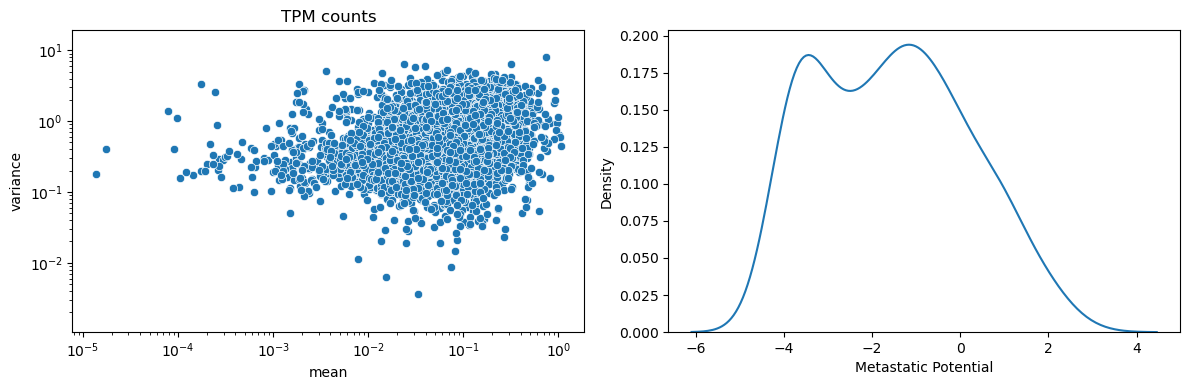

In [160]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 4))
ax = ax.flatten()

# subplot 1
i = 0
sns.scatterplot(data = stats_novst, x = 'mean', y = 'variance', ax = ax[i])
ax[i].set_xscale('log')
ax[i].set_yscale('log')
ax[i].set_title('TPM counts')

# subplot 2
# i += 1
# sns.scatterplot(data = stats, x = 'mean', y = 'variance', ax = ax[i])
# ax[i].set_xscale('symlog')
# ax[i].set_yscale('log')
# ax[i].set_title('VST counts')
# ax[i].yaxis.set_major_locator(ticker.FixedLocator([0.01, 0.1, 1, 10]))
# ax[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))

# # subplot 3
# i+=1
# sns.kdeplot(nexpr.sum().tolist(), ax = ax[i])
# ax[i].set_xlabel('Sample-wise TPM Count Sum')
# # ax[i].set_xscale('log')

# subplot 4
i+=1
sns.kdeplot(data=mp, x='mean', ax = ax[i])
ax[i].set_xlabel('Metastatic Potential')

fig.tight_layout()
;

In [161]:
mp.to_csv(os.path.join(data_path, 'processed', 'metastatic_potential_protein.csv'))
expr.to_csv(os.path.join(data_path, 'processed', 'expr_protein.csv'))